In [58]:
import sys
import seaborn as sns
import os
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import avalanches as crfn
import admin_functions as adfn
import plot as pltfn
import scipy
from scipy import stats 
import IS as isfn
import network as netfn

sns.reset_orig()
#plt.style.use('dark_background')
%load_ext autoreload
%autoreload

# Define paths
#---------------------------------------------------------------------------
Fdrop = '/Users/dominicburrows/Dropbox/PhD/analysis/'
Fmac = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'
Ftm = '/Volumes/Dominic Time Machine/'
experiment = 'PTZ-WILDTYPE'
savepath = Fdrop + 'Project/' + experiment + os.sep 

sys.version

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'3.8.3 (default, Jul  2 2020, 11:26:31) \n[Clang 10.0.0 ]'

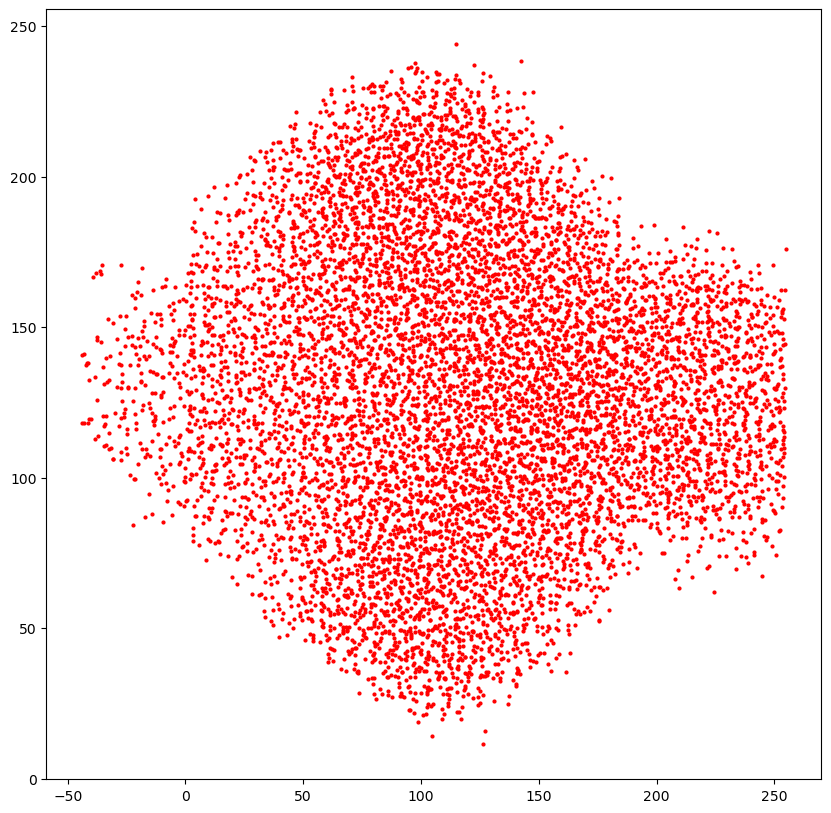

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     

# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
node = sorted(glob.glob('knodes*'))
fig,axarr = plt.subplots(figsize = (10,10))
nodes = np.load(node[0])
axarr.scatter(nodes[:,0], nodes[:,1], s = 4, color = 'red' , alpha = 1)
plt.show()

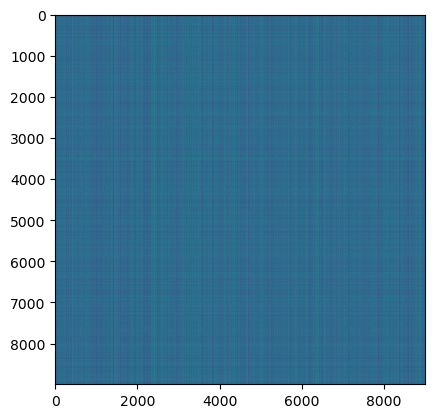

In [4]:
# K LIN + P LIN SCALE 
import numpy as np
import matplotlib.pyplot as plt
dist = euclidean_distances(nodes)
plt.imshow(dist)
plt.show()

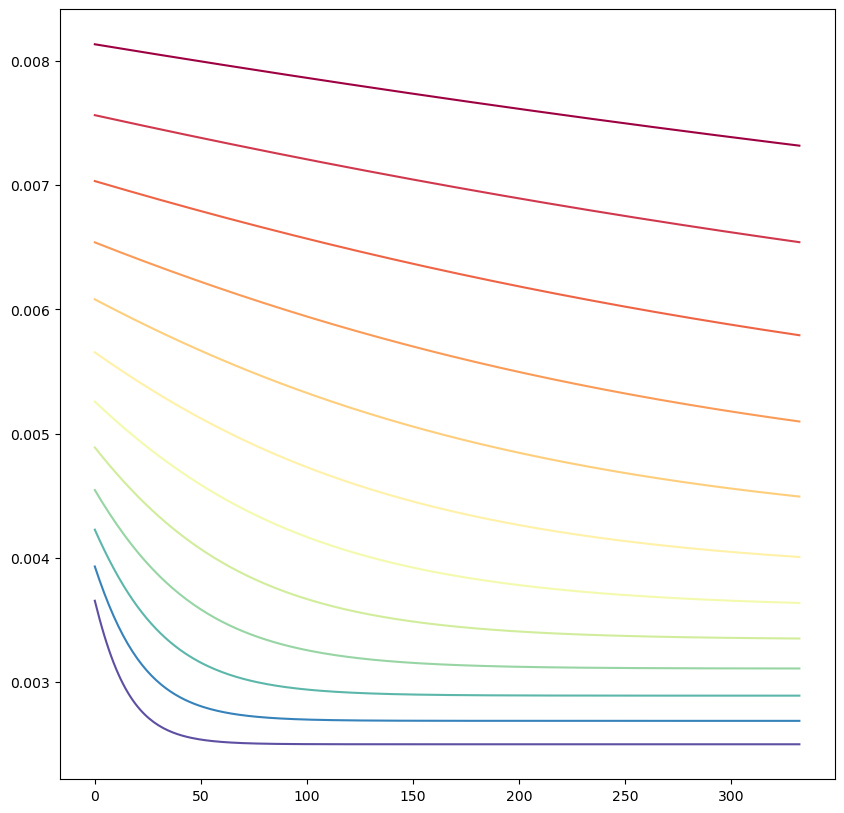

In [5]:
# Simple sigmoid function to 'soften' the exponential
#-------------------------------------------------------------------------------
def sig(x):
  return 1 / (1+np.exp(-x))

# Conversion from distance to edge weights, scaled (itself exponentially) by s
#-------------------------------------------------------------------------------
def dist2edge(distance, divisor, s):
  edgeweights = np.exp(s/5)*sig(np.exp(-soften/np.exp(s)*distance))/divisor
  return edgeweights

#S parameters
Nsteps  = 12
divisor = 200
soften = 0.07
s_vals   = np.array(np.linspace(0, 4, Nsteps)).tolist()

#Plot each s value
fig, ax = plt.subplots(1, figsize=(10,10))
colors  = cm.Spectral_r(np.linspace(0,1,Nsteps))
distance = np.linspace(0, np.max(dist), 300)
for s in range(len(s_vals)):
  ax.plot(distance, dist2edge(distance, divisor, s_vals[s]), c=colors[s])
plt.show()


In [6]:
# Choose path and create lists of coord and trace files
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
blnlist = sorted(glob.glob('*BLN*_av.npy*'))[:1]
p20list = sorted(glob.glob('*PTZ20*_av.npy*'))[:1]

In [25]:
blnlist

['PTZ-WILDTYPE-02_2photon_sess-01-6dpf_BLN_run-01_av.npy']

In [7]:
choose = 0
bln_distlist = [np.load(blnlist[i])[choose] for i in range(len(blnlist))]
p20_distlist = [np.load(p20list[i])[choose] for i in range(len(p20list))]
bln_vec = []
p20_vec = []
for i in range(len(bln_distlist)):
    bln_vec = np.append(bln_vec, bln_distlist[i])
    p20_vec = np.append(p20_vec, p20_distlist[i])

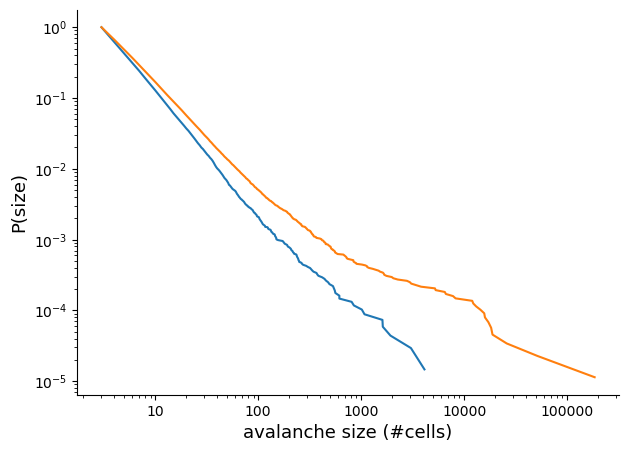

In [8]:
import matplotlib
import powerlaw
fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)
avdistcut = p20_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)

axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [11]:
#Calculate number of simulatons to do - to have 95% chance of generating maximum avalanche
def num_sims(empirical, cutoff):
    import matplotlib.pyplot as plt
    import math
    fig, axarr = plt.subplots(figsize = (7,5))
    hist = axarr.hist(empirical, bins = 100000, density = True, histtype = 'step', cumulative = -1)
    p = 1-(10**(np.log10(hist[0])[np.where(np.log10(hist[1]) > np.log10(cutoff))[0][0]])) #probability of getting avalanches of size cutoff or smaller
    number = 0.05 
    base = p
    exponent = int(math.log(number, base)) #number of simulations as the power to which p is raised to get 95% probability 
    return(exponent)

#Simulation parameters
#======================
cutoff = 1000
n_sims= num_sims(bln_vec, cutoff)
n_sims

29156

In [56]:
#Check paramaters
s0 = s_vals[0]
k0 = 11

print('divisor = ' + str(divisor))
print('soften = ' + str(soften))
print('cutoff = ' + str(cutoff))
print('n_sims = ' + str(n_sims))
print('s0 = ' + str(s0))
print('k0 = ' + str(k0))

divisor = 200
soften = 0.07
cutoff = 1000
n_sims = 29156
s0 = 0.0
k0 = 11


In [ ]:
#Parameter sweep
from scipy.optimize import minimize
from scipy.optimize import brute
from scipy import stats
total_list = []
def ks_dist(params):
    print(params)  # <-- you'll see that params is a NumPy array
    s, k  = params # <-- for readability you may wish to assign names to the component variables
    avs = netfn.ba_netsim(dist).simulate(s, int(k), 0.6,  divisor, soften, cutoff, n_sims, 1).av_size
    ks = stats.ks_2samp(empirical, avs)[0]
    total_list.append([params, ks, avs])
    print('ks = ' + str(ks))
    return ks

#Define params
empirical = bln_vec
dist = dist
#initial_guess = [s0, k0]
#bnds = ( (0,5), (10, 100))
#result = minimize(ks_dist, initial_guess, bounds = bnds, method = 'BFGS')
ranges = (slice(0, 5, 0.1), slice(10, 35, 1))
result = brute(ks_dist, ranges)

In [104]:
os.chdir(Fdrop + 'Project/' + experiment)

costlist, paramlist, avlist = list(range(len(total_list))), list(range(len(total_list))), list(range(len(total_list)))
for i in range(len(total_list)):
    paramlist[i] = total_list[i][0]
    costlist[i] = total_list[i][1]
    avlist[i] = total_list[i][2]
    
np.save('optimise_brute_ksdistlow_ba_blnf1_params.npy',   paramlist)
np.save('optimise_brute_ksdistlow_ba_blnf1_cost.npy',    costlist)
np.save('optimise_brute_ksdistlow_ba_blnf1_avs.npy',  avlist)

print('iterations = ' + str(len(costlist)) + '  true min = ' + str(np.where(costlist == np.min(costlist))[0][0]))
print('min cost = ' + str(costlist[np.where(costlist == np.min(costlist))[0][0]]))
print('min params = ' + str(paramlist[np.where(costlist == np.min(costlist))[0][0]]))
curr = avlist[np.where(costlist == np.min(costlist))[0][0]]

iterations = 1651  true min = 313
min cost = 0.007743892213270764
min params = [ 1.2 23. ]


In [88]:
# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
param = sorted(glob.glob('optimise*'+ '*params.npy'))
cost = sorted(glob.glob('optimise*' + '*cost.npy'))
avs = sorted(glob.glob('optimise*' + '*avs.npy'))


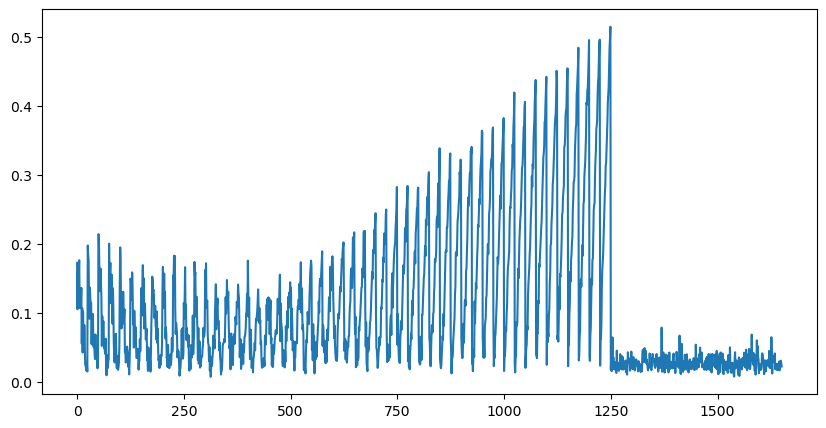

In [105]:
fig = plt.figure(figsize= (10,5))
plt.plot(np.arange(0, len(costlist)), costlist)
plt.show()

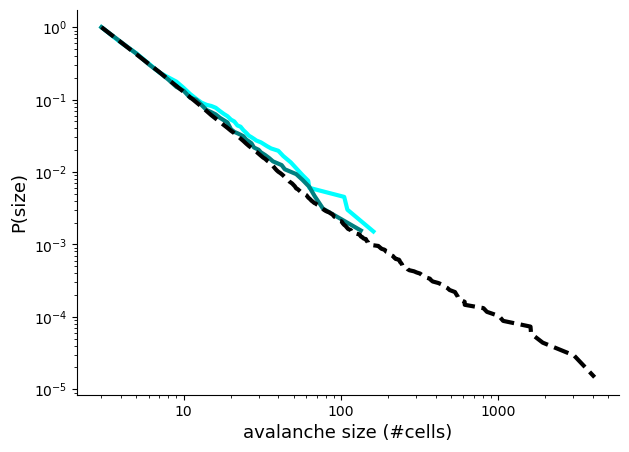

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   

avdistcut = avlist[-1]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')

avdistcut = avlist[np.where(costlist == np.min(costlist))[0][0]]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'teal')

avdistcut = empirical
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

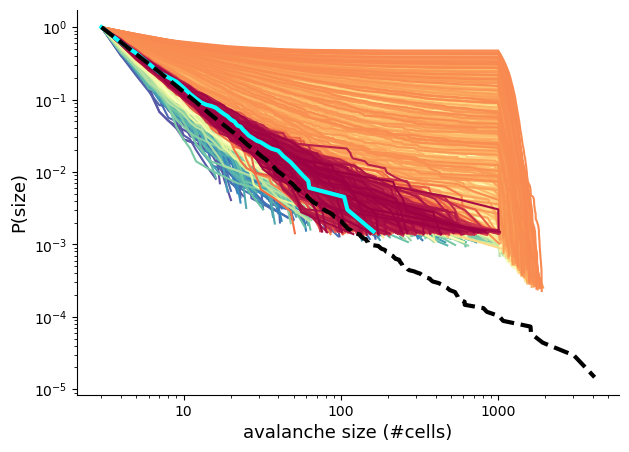

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


colors = cm.Spectral_r(np.linspace(0, 1, len(total_list)))

#Cycle length - small network
import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
# Node coordinates
#---------------------------------------------------------------------------
for i in range(len(total_list)):
    av_dense = total_list[i][2]
    powerlaw.plot_ccdf(av_dense, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
    

avdistcut = total_list[-1][2]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')

avdistcut = empirical
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     

# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
avlist = sorted(glob.glob('optimise*ks*ba+*avs.npy'))
costlist = sorted(glob.glob('optimise*ks*ba+*cost.npy'))
paramlist = sorted(glob.glob('optimise*ks*ba+*params.npy'))
avlist, costlist, paramlist

(['optimise_brute_ksdist_ba+re0.6_blnf1_avs.npy',
  'optimise_brute_ksdist_ba+re0.6_p20f1_avs.npy'],
 ['optimise_brute_ksdist_ba+re0.6_blnf1_cost.npy',
  'optimise_brute_ksdist_ba+re0.6_p20f1_cost.npy'],
 ['optimise_brute_ksdist_ba+re0.6_blnf1_params.npy',
  'optimise_brute_ksdist_ba+re0.6_p20f1_params.npy'])

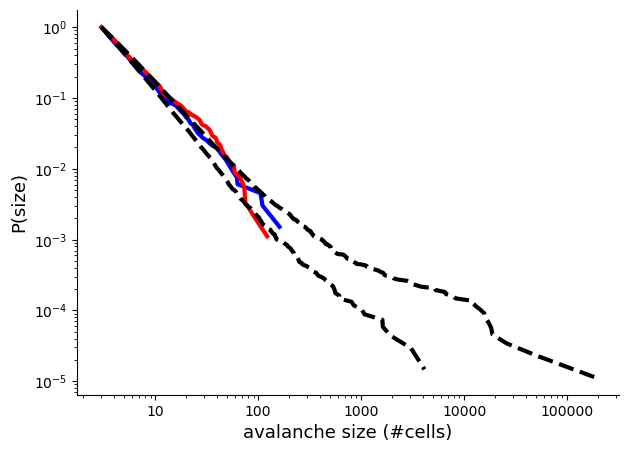

baseline = [ 1.20035156 24.42626953]
ptz = [ 2.91109167 18.81563224]


In [110]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy

import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
avdistcut = np.load(avlist[0], allow_pickle=True)[-1]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'blue')

avdistcut = np.load(avlist[1], allow_pickle=True)[-1]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'red')

avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')

avdistcut =p20_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

print('baseline = ' + str(np.load(paramlist[0], allow_pickle=True)[-1]))
print('ptz = ' + str(np.load(paramlist[1], allow_pickle=True)[-1]))

In [ ]:
os.chdir(F10t + 'Project/' + experiment)
#Network parameters (k,p)
#=====================
kslist = np.zeros((len(k_vals), len(s_vals)))
for i in range(len(k_vals)):
    kname = '_k-' + str(k_vals[i]) 
    s_list = sorted(glob.glob('ba-net-paramsweep*' + kname + '-*' + 'av_size*'))
    for z in range(len(s_list)):
        av_sparse = scipy.sparse.load_npz(s_list[z])
        av_dense = np.array(av_sparse.todense())[0]
        empirical = bln_vec

        if len(av_dense) == 0:
            kslist[i, z] = 0
        else:
            kslist[i, z] = stats.ks_2samp(empirical, av_dense)[0]
            
            
#KS distance
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
curr = kslist[1:]
divnorm = colors.DivergingNorm(vmin=min(np.ravel(curr)), vcenter=np.median(np.ravel(curr)), vmax=max(np.ravel(curr)))
f, ax = plt.subplots(figsize = (8,5))
plot1 = ax.imshow(curr, cmap = 'Spectral_r', norm = divnorm)
ax.set_xlabel('s', size = '15')
ax.set_ylabel('k', size = '15')
#ax.locator_params(axis='y', nbins=10)
#ax.locator_params(axis='x', nbins=20)
divider = make_axes_locatable(ax)
cax0 = divider.append_axes("right", size="5%", pad=0.05)
cbar0 = f.colorbar(plot1, cax=cax0, label = 'α')
plt.show()